In [1]:
#libraries used
import numpy as np
from numpy import array
import pandas as pd
from pandas import *
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy import signal
from scipy.stats import mannwhitneyu
import random
import statistics
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.graphics.tsaplots import plot_acf

Reading the csv file from keras(Electric_Production)

In [2]:
data = read_csv(r'C:\Users\User\Desktop\Projects\Time_Series\Data\Electric_Production.csv')

In [3]:
data

,DATE,Current
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [4]:
#Converting to date-time format
data['DATE'] = pd.to_datetime(data['DATE'])

In [5]:
#checking for missing data
print(data.isnull().sum())

DATE       0
Current    0
dtype: int64


As it can be seen, there is no missing data. 

In [6]:
current_val = data['Current'][:]

In [7]:
years = [data['DATE'][i].year for i in range(len(data['DATE']))]
months = [data['DATE'][i].month for i in range(len(data['DATE']))]

In [8]:
print('Number of appearances for each year:',Counter(years))

Number of appearances for each year: Counter({1985: 12, 1986: 12, 1987: 12, 1988: 12, 1989: 12, 1990: 12, 1991: 12, 1992: 12, 1993: 12, 1994: 12, 1995: 12, 1996: 12, 1997: 12, 1998: 12, 1999: 12, 2000: 12, 2001: 12, 2002: 12, 2003: 12, 2004: 12, 2005: 12, 2006: 12, 2007: 12, 2008: 12, 2009: 12, 2010: 12, 2011: 12, 2012: 12, 2013: 12, 2014: 12, 2015: 12, 2016: 12, 2017: 12, 2018: 1})


It seems that the data point are equidistant in time.

Let's start with some Exploratory Data Analysis

----------------------------------------------------------------------------------------------------------------------------------

### EDA

#### Boxplots, histogram with best fitted distributions & statistics

In [9]:
#Statistics
print('The mean of the current values is:', np.mean(current_val))
print('The median of the current values is:', np.median(current_val))
print('The mode of the current values is:', statistics.mode(current_val))
print('Standard deviation of the current values:', np.std(current_val))
print('Quartiles:',np.quantile(current_val,[0,0.25,0.5,0.75,1]))

The mean of the current values is: 88.84721763224181
The median of the current values is: 89.7795
The mode of the current values is: 72.5052
Standard deviation of the current values: 15.368441302061292
Quartiles: [ 55.3151  77.1052  89.7795 100.5244 129.4048]


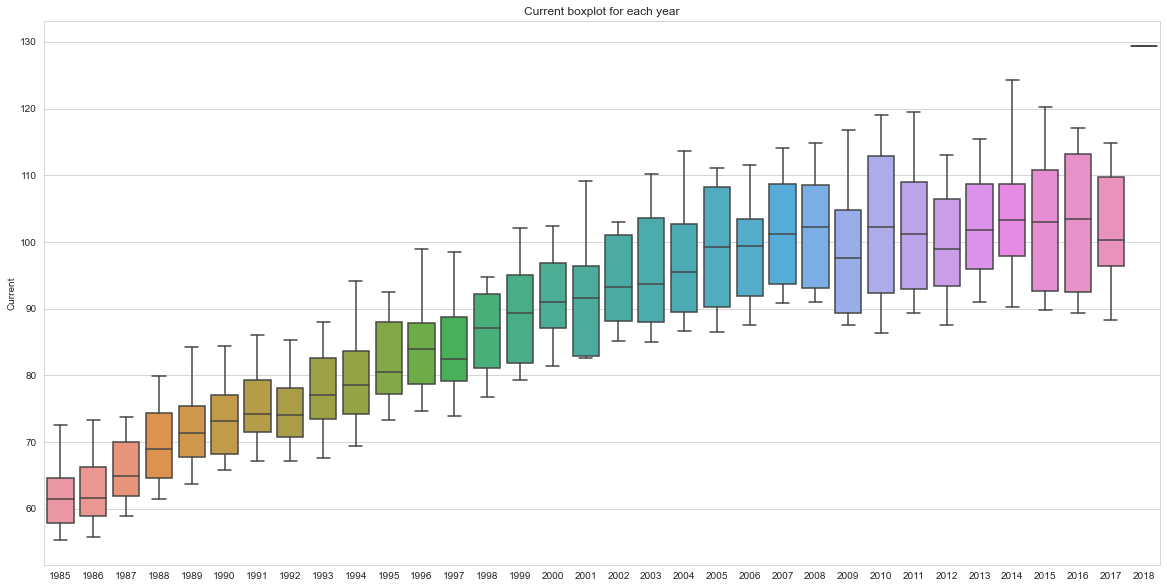

In [10]:
#Boxplots for each year
plt.figure(figsize = (20,10))
sns.set_style('whitegrid')
ax = sns.boxplot(x = years, y = data['Current'])
ax.set_title('Current boxplot for each year')
plt.show()

Interpretation: As it can be seen the electric production follows an increasing pattern among th eyears, and seems to begin a smaller increasing pattern (but more data is necessary for this statement). The clear thing is that the electric production follows a log increasing pattern, as it can be seen from the run-plot below which also containins the moving average.  

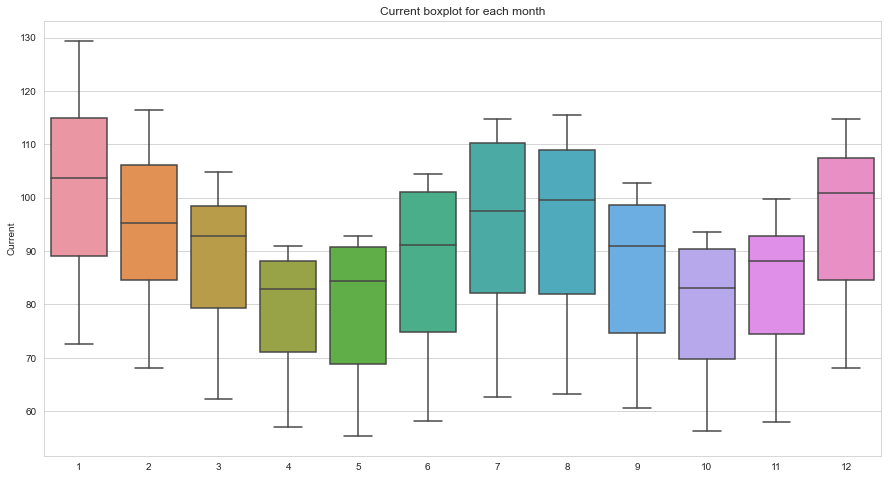

In [11]:
#Boxplots for each month
plt.figure(figsize = (15,8))
sns.set_style('whitegrid')
ax = sns.boxplot(x = months, y = data['Current'])
ax.set_title('Current boxplot for each month')
plt.show()

Interpretation: Bigger electric production to the year edges, with one more increasment in third quarter of the year. 

The best fitted distribution for the Current data is: {'norm': {'loc': 88.84721763224182, 'scale': 15.368441302061287}}


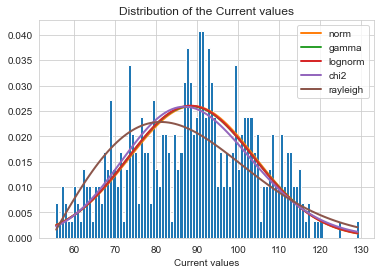

In [12]:
#Histogram and best fitted distributions
f = Fitter(current_val,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the Current data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Current values')
plt.title('Distribution of the Current values')
plt.show()

Let's see if the current values are somhow connected (correlated) to eachother

#### Lag & Autocorrelation plots

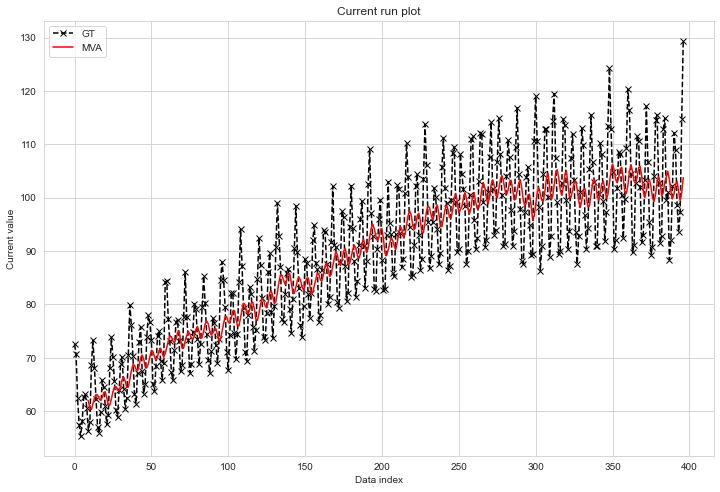

In [13]:
#Run plot and mva
mva = current_val.rolling(10).mean()
mva = mva[9:]
xx = np.linspace(9,len(current_val)-1,len(mva))

plt.figure(figsize = (12,8))
plt.plot(current_val,'--kx')
plt.plot(xx,mva,'r')
plt.xlabel('Data index')
plt.ylabel('Current value')
plt.title('Current run plot')
plt.legend(['GT','MVA'])
plt.show()

<Figure size 432x288 with 0 Axes>

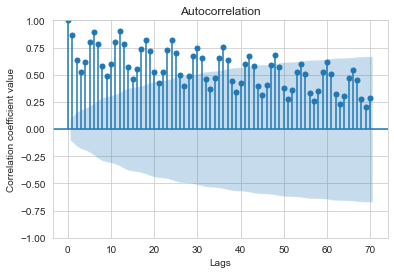

In [14]:
plt.figure()
plot_acf(x = current_val, lags=70)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient value')
plt.show()

As it can be seen from the autocorrelation plot above, a significant can also be found at a lag of 48 (until the correlation values are inside the conffidence area). Also the peaks are observed at the following lag values: 0, 6, 12, 18... i.e. a period equal to 6 starting form 0. Let's vizualise some lag plots for this lags, in order to see if the insight observed in the autocorrelation plot is confirmed.

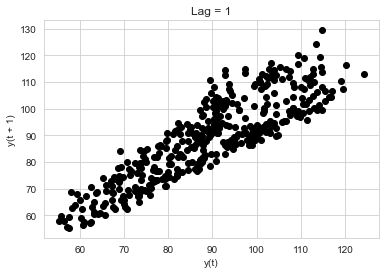

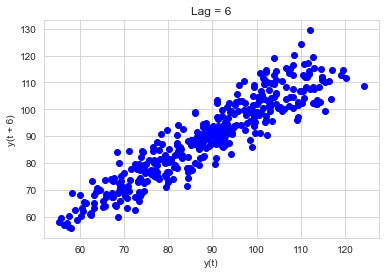

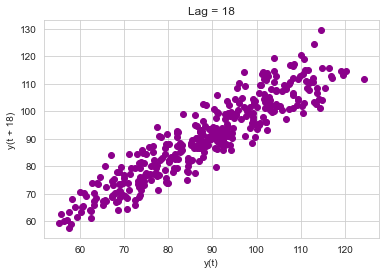

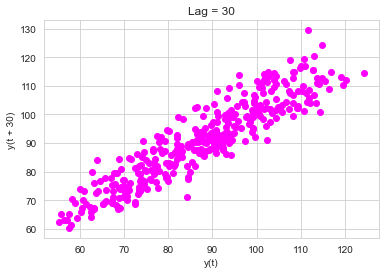

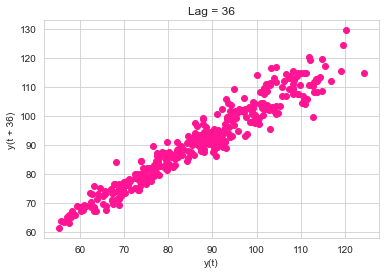

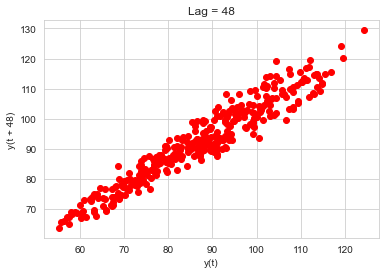

In [15]:
lags = [1,6,18,30,36,48]
colors = ['black', 'blue', 'darkmagenta', 'magenta', 'deeppink', 'red']
for i in range(len(lags)):
    plt.figure()
    pd.plotting.lag_plot(current_val,lag =lags[i], c = colors[i])
    plt.title('Lag = '+str(lags[i]))
    plt.show()

As it can be seen from the scatter plots aboce, the correlation exists for lags of the form 6k.

Since the run-plot of the current values is looking a little bit sinusoidal, let's check for some potential frequency by plotting the estimative PSD using Welsch's method.

#### PSD

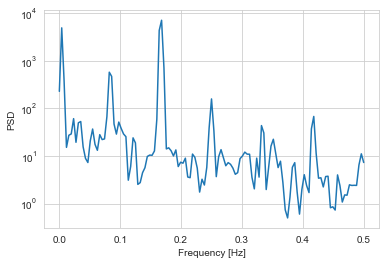

In [16]:
freq, psd = signal.welch(current_val)
plt.figure()
plt.semilogy(freq, psd)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.show()

As it can be seen, the biggest peak is observed at approx. 0.175Hz, which make me think that is the main frequency. 

Next, let's continue with some predictions. I'll choose more models: GPR, XGBoost, Random Forest, and after comparing the results. Also, I'll perform downsampling for the training data to see if the accuracy will be close to the original one (or maybe even improved).

----------------------------------------------------------------------------------------------------------------------------------

### PCA, Clustering, Train&Test Data

Let's structure the data using mini-batches of a given length (here, I'll choose 10, i.e.: use 10 point to predict the eleventh).

In [17]:
step = 1
window = 4

In [18]:
#DATA--------------------------------------------
XX = current_val.to_numpy()
generator = TimeseriesGenerator(XX, XX, stride=step, length=window, batch_size=len(XX))
shape_0 = generator[0][0].shape[0]
#print('shape_0:',shape_0)
ts_x = generator[0][0].reshape(shape_0, -1)
ts_y = generator[0][1]
#print('ts_x shape:',ts_x.shape)
#print('ts_y shape:',ts_y.shape)
x_tt = ts_x.astype('float')
y_tt = ts_y.astype('float').reshape(-1,1)
#print('x_tt shape:',x_tt.shape)
#print('y_tt shape:',y_tt.shape)
X = x_tt
y = y_tt

Randomly choosing 75% for train and 25% for test.

In [19]:
index_list = list(np.linspace(0,shape_0-1,shape_0))
index_list = [int(index_list[i]) for i in range(shape_0)]
train_index = random.sample(index_list,int((7.5*shape_0)/10))
train_index = np.sort(train_index)
test_index = [index_list[i] for i in range(shape_0) if index_list[i] not in train_index]
test_index = np.sort(test_index)

In [20]:
X_train_all = X[train_index[0]][:]
y_train_all = y[train_index[0]][:]
X_test = X[test_index[0]][:]
y_test = y[test_index[0]][:]
for i in range(1,len(train_index)):
    X_train_all = np.vstack((X_train_all,X[train_index[i]][:]))
    y_train_all = np.vstack((y_train_all,y[train_index[i]][:]))
for i in range(1,len(test_index)):
    X_test = np.vstack((X_test,X[test_index[i]][:]))
    y_test = np.vstack((y_test,y[test_index[i]][:]))

print('X_train_all shape:',X_train_all.shape)
print('y_train_all shape:',y_train_all.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_all shape: (294, 4)
y_train_all shape: (294, 1)
X_test shape: (99, 4)
y_test shape: (99, 1)


#### Down-sampling

In [21]:
df = pd.DataFrame(X_train_all)

#### Scaling & PCA

In [22]:
#SCALING----------------------------------------------
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
#PCA-2-components---------------------------------------
pca_2c = PCA(n_components = 2)
X_pca_2c = pca_2c.fit_transform(df_scaled)
#VARIANCE-----------------------------------------------
print(pca_2c.explained_variance_ratio_.sum() * 100,'% of the variance is explained with these two components')   

95.20722324724488 % of the variance is explained with these two components


#### Clustering (using DBSCAN)

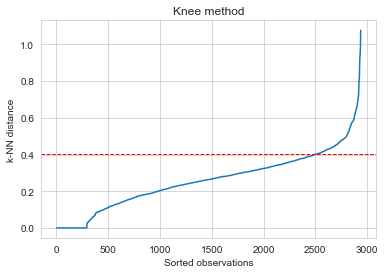

!!! -1 for noisy points !!!
Cluster points: Counter({2: 161, 0: 59, -1: 42, 1: 32})


In [23]:
nr_neigh = 10
#KneeMethod---------------------------------
nbrs = NearestNeighbors(n_neighbors=nr_neigh).fit(X_pca_2c)
neigh_dist, neigh_ind = nbrs.kneighbors(X_pca_2c,nr_neigh) #!!!
k_dist = []
for i in range(neigh_dist.shape[0]):
    for j in range(neigh_dist.shape[1]):
        k_dist.append(neigh_dist[i][j])
k_dist = np.sort(k_dist)
#-------------------------------------------
slope_len = 150
for i in range(int(4*len(k_dist)/5),len(k_dist)-slope_len):
    #print(i)
    j = i+slope_len
    slope_val = (k_dist[j]-k_dist[i])/((j-i)*(max(k_dist)/len(k_dist)))
    if slope_val > math.tan(math.pi/18):
        #ind_eps = i+int(slope_len/2)
        ind_eps = j
        break
epsilon = k_dist[ind_eps]
#----------------------------------------------------------------------------
plt.plot(k_dist)
plt.axhline(y=epsilon, linewidth=1, linestyle='dashed', color='r') #the knee
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations")
plt.title('Knee method')
plt.grid(True)
plt.show()
#----------------------------------------------------------------------------
dbs_clust = DBSCAN(eps = epsilon,min_samples = nr_neigh).fit(X_pca_2c)
labels = dbs_clust.labels_
unique_labels = np.unique(labels)
print('!!! -1 for noisy points !!!')
print('Cluster points:',Counter(dbs_clust.labels_))


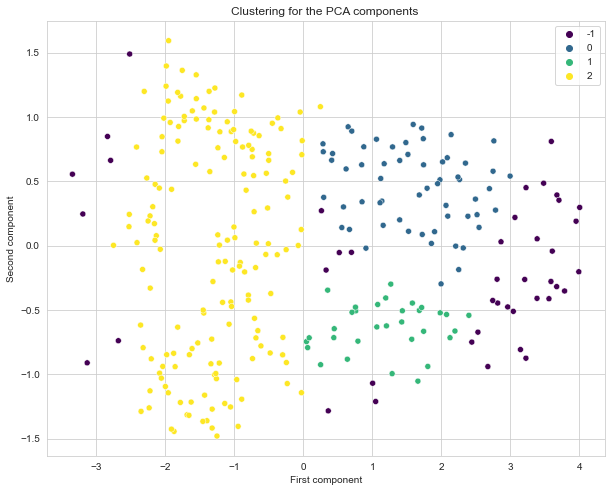

In [24]:
plt.figure(figsize = (10,8))
sns.scatterplot(data=X_pca_2c, x=X_pca_2c[:,0], y=X_pca_2c[:,1], hue=labels, legend="full", palette="viridis")
#sns.move_legend(loc = "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Clustering for the PCA components ')
plt.grid(True)
plt.show()

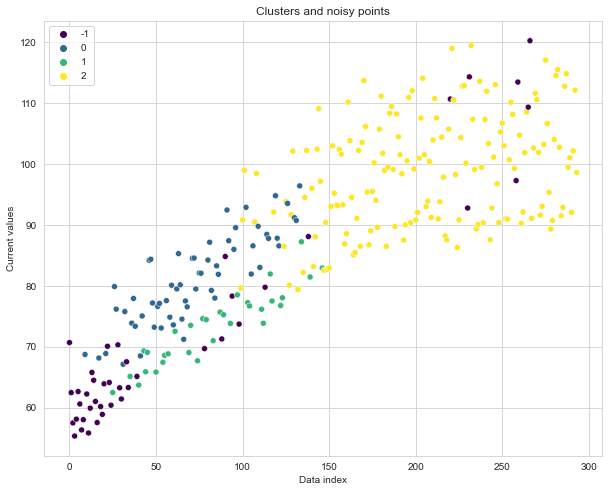

In [25]:
xx = np.linspace(0,len(X_pca_2c[:,0])-1,len(X_pca_2c[:,0]))
yy = [current_val[i] for i in train_index]
plt.figure(figsize = (10,8))
sns.scatterplot(x = xx,y = yy,hue=labels, legend="full", palette="viridis")
plt.xlabel('Data index')
plt.ylabel('Current values')
plt.title('Clusters and noisy points')
plt.grid(True)
plt.show()

In [26]:
ind_labels = []
for i in range(len(unique_labels)):
    val = unique_labels[i]
    indexes = []
    for j in range(len(labels)):
        if labels[j] == val:
            indexes.append(j)
    ind_labels.append(indexes)

Let's construct train matrices with the outliers and only 25% data from clusters.

In [36]:
def get_ind_down(a):
    '''
    Input: a - list of integers
    Output: d - list of 25% values from a
    '''
    d = random.sample(a,int((2.5*len(a))/10))
    d = np.sort(d)
    return d

In [37]:
ind_train = ind_labels[0]
for i in range(1,len(ind_labels)):
    seq = get_ind_down(ind_labels[i])
    ind_train = np.hstack((ind_train,seq))
    ind_train = np.sort(ind_train)

In [38]:
test_index = [test_index[i]+2 for i in range(len(test_index))]

In [39]:
X_train = X_train_all[ind_train[0]][:]
y_train = y_train_all[ind_train[0]][:]
for ind in ind_train[1:]:
    X_train = np.vstack((X_train,X_train_all[ind][:]))
    y_train = np.vstack((y_train,y_train_all[ind][:]))

print(X_train.shape)
print(y_train.shape)

(104, 4)
(104, 1)


Let's see if the distribution is the same for the downsamoled data as for the complete data. In order to do that, I'll use Kruskal-Wallis test and some visualizations.

In [40]:
y_tr_all = y_train_all.reshape(-1,)
y_tr_down = y_train.reshape(-1,)
print('Kruskal Wallis statistic test results for the expected values (y) data:', stats.kruskal(y_tr_all,y_tr_down))

Kruskal Wallis statistic test results for the expected values (y) data: KruskalResult(statistic=7.033229436042216, pvalue=0.008001093756076072)


The best fitted distribution for the downsampled expected data (y) is: {'norm': {'loc': 83.9215971153846, 'scale': 15.08527928778491}}


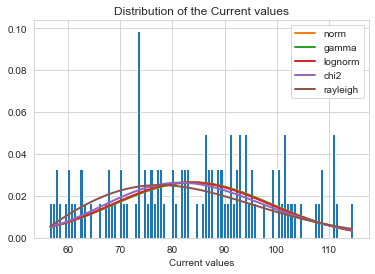

In [41]:
#Histogram and best fitted distributions for y_train_all and y_train
f = Fitter(y_train,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the downsampled expected data (y) is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Current values')
plt.title('Distribution of the Current values')
plt.show()

As it can be seen, the best distribution is still the Normal distribution and the p-value resulted from the statistic Kruskal - Wallis test is good enough.

Next, I'll train SGPR, XGBoost and Random Forest with both: complete (X_train all, y_train_all) and downsampled (X_train, y_train) data sets, and compare accuracies.

----------------------------------------------------------------------------------------------------------------------------------

#### Training models

In [42]:
def mape(y_a,y_p):
    val = np.mean(np.abs(((y_a-y_p)/y_a)))*100
    return val

In [43]:
def nrmse(y_a,y_p):
    mse = mean_squared_error(y_a,y_p)
    rmse = np.sqrt(mse)
    val = rmse/np.mean(y_a)
    return val

----------------------------------------------------------------------------------------------------------------------------------

##### SGPR (Sparse Gaussian Process Regression)

In [44]:
import warnings
warnings.filterwarnings('ignore')
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary
import time

###### All data

In [45]:
#kernel
k1 = gpflow.kernels.Matern12()

In [47]:
st = time.time()
m1 = gpflow.models.sgpr.SGPR_with_posterior(data = (X_train_all, y_train_all), kernel = k1, inducing_variable = X_train_all[::int(window)])
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m1.training_loss, m1.trainable_variables, options=dict(maxiter=100))
et = time.time()

In [48]:
print('Running time for training SGPR with all data is:', et-st,'s')

Running time for training SGPR with all data is: 1.3076002597808838 s


In [49]:
print_summary(m1)

╒═════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════════╕
│ name                                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                             │
╞═════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════════╡
│ SGPR_with_posterior.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 574.72347                         │
├─────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────────┤
│ SGPR_with_posterior.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 615.92847                         │
├─────────────────────────────────────────┼───────────┼───────────────

###### Down-sampled data

In [50]:
#kernel
k2 = gpflow.kernels.Matern12()

In [51]:
st = time.time()
m2 = gpflow.models.sgpr.SGPR_with_posterior(data = (X_train, y_train), kernel = k2, inducing_variable = X_train[::int(window)])
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m2.training_loss, m2.trainable_variables, options=dict(maxiter=100))
et = time.time()

In [52]:
print('Running time for training SGPR with downsampled data is:', et-st,'s')

Running time for training SGPR with downsampled data is: 1.035797357559204 s


In [53]:
print_summary(m2)

╒═════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════════╕
│ name                                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                             │
╞═════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════════╡
│ SGPR_with_posterior.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1146.35258                        │
├─────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────────┤
│ SGPR_with_posterior.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1046.53095                        │
├─────────────────────────────────────────┼───────────┼───────────────

Now, we have the trained models. Let's see how the results are looking using the test data. 

In [54]:
pred_val_all,_ = m1.predict_f(X_test)

In [55]:
pred_val_down,_ = m2.predict_f(X_test)

In [56]:
print("MAPE for full data:",mape(y_test,pred_val_all),'%')
print('MAPE for down-sampled data:', mape(y_test,pred_val_down),'%')
print('NRMSE for all data:', nrmse(y_test,pred_val_all),'%')
print('NRMSE for down-smapled data:', nrmse(y_test,pred_val_down),'%')
#for accuracy, I'll use the mapes
acc_sgpr_all = round(100-mape(y_test,pred_val_all),2)
acc_sgpr_down = round(100-mape(y_test,pred_val_down),2)
print('Accuracy for the full training data SGPR model:', acc_sgpr_all,'%')
print('Accuracy for the down-sampled training data SGPR model:', acc_sgpr_down,'%')

MAPE for full data: 2.9837650729522287 %
MAPE for down-sampled data: 3.782224546141675 %
NRMSE for all data: 0.03799225181546687 %
NRMSE for down-smapled data: 0.04900535191294197 %
Accuracy for the full training data SGPR model: 97.02 %
Accuracy for the down-sampled training data SGPR model: 96.22 %


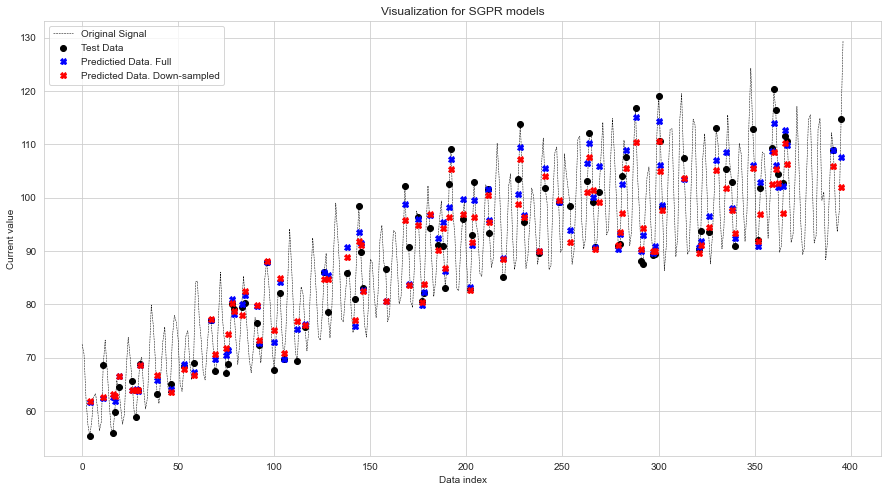

In [57]:
plt.figure(figsize = (15,8))
plt.plot(current_val,'--k',linewidth = 0.5)
plt.scatter(test_index,y_test,c='black')
plt.plot(test_index,pred_val_all,'bX')
plt.plot(test_index,pred_val_down,'rX')
plt.xlabel('Data index')
plt.ylabel('Current value')
plt.title('Visualization for SGPR models')
plt.grid(True)
plt.legend(['Original Signal','Test Data','Predictied Data. Full','Predicted Data. Down-sampled'],loc = 'best')
plt.show()

----------------------------------------------------------------------------------------------------------------------------------

##### XGBoost

In [58]:
import xgboost as xgb
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import accuracy_score

###### All data

In [59]:
m3 = xgb.XGBRegressor()
m3.fit(X_train_all,y_train_all)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

##### Down-sampled Data

In [60]:
m4 = xgb.XGBRegressor()
m4.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [61]:
y_pred_all = m3.predict(X_test)
y_pred_down = m4.predict(X_test)
print('MAPE for XGBoost before tuning for full data:',mape(y_test,y_pred_all),'%')
print('MAPE for XGBoost before tuning for down-sampled data:',mape(y_test,y_pred_down),'%')
print('NRMSE for XGBoost before tuning for full data:',nrmse(y_test,y_pred_all),'%')
print('NRMSE for XGBoost before tuning for down-sampled data:',nrmse(y_test,y_pred_down),'%')

MAPE for XGBoost before tuning for full data: 21.003262255433054 %
MAPE for XGBoost before tuning for down-sampled data: 20.180261044398613 %
NRMSE for XGBoost before tuning for full data: 0.05053443968045005 %
NRMSE for XGBoost before tuning for down-sampled data: 0.058465416806277405 %


As it can be seen, the model is not as accurate as we would like. Therefore let's tune the models parameters in order to get better results.

##### Hypermparameters tuning (Bayesian Optimization with HYPEROPT)

In [62]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, anneal
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [63]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
       
    }

In [64]:
# space = {'max_depth': hp.quniform("max_depth", 3, 14, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.uniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.uniform('min_child_weight', 0, 10,1),
#         'n_estimators': 200,
#         'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
#         'tree_method':'gpu_hist', 
#         'seed': 0,
#         'random_state': 5, 
#         'max_bin': scope.int(hp.quniform('max_bin', 200, 550, 1))}

In [65]:
def hyperparameter_tuning_full(space):
    model3 = xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']), reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']), 
                    colsample_bytree=int(space['colsample_bytree']))
    evaluation = [(X_train_all, y_train_all), (X_test, y_test)]
    model3.fit(X_train_all, y_train_all, eval_set=evaluation, eval_metric="rmse", early_stopping_rounds=100, verbose=False)
    pred = model3.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print ("SCORE:", rmse)
    return {'loss':rmse, 'status': STATUS_OK, 'model': model3}

In [66]:
def hyperparameter_tuning_down(space):
    model4 = xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']), reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model4.fit(X_train, y_train, eval_set=evaluation, eval_metric="rmse", early_stopping_rounds=100, verbose=False)
    pred = model4.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print ("SCORE:", rmse)
    return {'loss':rmse, 'status': STATUS_OK, 'model': model4}

In [67]:
trials3 = Trials()
best_hyperparam_full = fmin(fn=hyperparameter_tuning_full, space=space, algo=tpe.suggest, max_evals=100, trials=trials3)

SCORE:                                                 
7.5960778655602095                                     
SCORE:                                                 
7.432374419965699                                                                
SCORE:                                                                           
7.333861314069723                                                               
SCORE:                                                                          
7.357520390611707                                                               
SCORE:                                                                          
6.808912735184399                                                               
SCORE:                                                                          
6.890695417471849                                                               
SCORE:                                                                          
6.48671847947352    

7.418946486683298                                                                
SCORE:                                                                           
6.632902550872935                                                                
SCORE:                                                                           
7.745440481144797                                                                
SCORE:                                                                           
7.303200502355783                                                                
SCORE:                                                                           
6.33405228431177                                                                 
SCORE:                                                                           
6.462943693438694                                                                
SCORE:                                                                           
7.08339512772100

100%|██████████| 100/100 [00:10<00:00,  9.22trial/s, best loss: 5.935827945380228]


In [68]:
m3_tuned = trials3.results[np.argmin([r['loss'] for r in trials3.results])]['model']
print(m3_tuned)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.033299064314879,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=14, max_leaves=0, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=180, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [69]:
trials4 = Trials()
best_hyperparam_down = fmin(fn=hyperparameter_tuning_down, space=space, algo=tpe.suggest, max_evals=100, trials=trials4)

SCORE:                                                 
9.09145834450712                                       
SCORE:                                                 
9.091636169463376                                                              
SCORE:                                                                         
8.43990538079998                                                               
SCORE:                                                                         
8.81711484939295                                                               
SCORE:                                                                         
9.07818367147273                                                               
SCORE:                                                                         
9.150189893844574                                                              
SCORE:                                                                         
10.528129515448777              

SCORE:                                                                          
9.027316940466598                                                               
SCORE:                                                                          
8.869782393845686                                                               
SCORE:                                                                          
10.530029133340303                                                              
SCORE:                                                                          
10.840906725575953                                                              
SCORE:                                                                          
9.079709285403709                                                               
SCORE:                                                                          
9.456373490914197                                                               
SCORE:                      

In [70]:
m4_tuned = trials4.results[np.argmin([r['loss'] for r in trials4.results])]['model']
print(m4_tuned)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.453526857516188,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=15, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=180, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [71]:
y_pred_opt_all = m3_tuned.predict(X_test)
y_pred_opt_down = m4_tuned.predict(X_test)
print('MAPE for XGBoost after tuning for full data:',mape(y_test,y_pred_opt_all),'%')
print('MAPE for XGBoost after tuning for down-sampled data:',mape(y_test,y_pred_opt_down),'%')
print('NRMSE for XGBoost after tuning for full data:',nrmse(y_test,y_pred_opt_all),'%')
print('NRMSE for XGBoost after tuning for down-sampled data:',nrmse(y_test,y_pred_opt_down),'%')
acc_xgb_all = round(100-mape(y_test,y_pred_opt_all),2)
acc_xgb_down = round(100-mape(y_test,y_pred_opt_down),2)
print('Accuracy for the full training data XGBoost model:', acc_xgb_all,'%')
print('Accuracy for the down-sampled training data XGBoost model:', acc_xgb_down,'%')

MAPE for XGBoost after tuning for full data: 20.127848160318376 %
MAPE for XGBoost after tuning for down-sampled data: 18.732869862306284 %
NRMSE for XGBoost after tuning for full data: 0.0660328825555149 %
NRMSE for XGBoost after tuning for down-sampled data: 0.09382337405636353 %
Accuracy for the full training data XGBoost model: 79.87 %
Accuracy for the down-sampled training data XGBoost model: 81.27 %


As it can be seen, the results are a little bit improved after tuning.

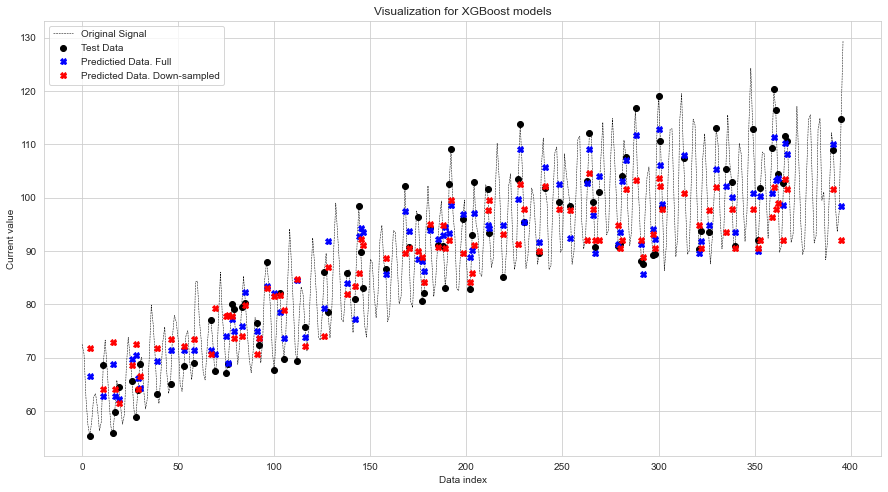

In [72]:
plt.figure(figsize = (15,8))
plt.plot(current_val,'--k',linewidth = 0.5)
plt.scatter(test_index,y_test,c='black')
plt.plot(test_index,y_pred_opt_all,'bX')
plt.plot(test_index,y_pred_opt_down,'rX')
plt.xlabel('Data index')
plt.ylabel('Current value')
plt.title('Visualization for XGBoost models')
plt.grid(True)
plt.legend(['Original Signal','Test Data','Predictied Data. Full','Predicted Data. Down-sampled'],loc = 'best')
plt.show()

----------------------------------------------------------------------------------------------------------------------------------

#### Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor

##### All Data

In [74]:
m5 = RandomForestRegressor(n_estimators = 100, random_state = 0)
m5.fit(X_train_all, y_train_all)

RandomForestRegressor(random_state=0)

##### Down-sampled Data

In [75]:
m6 = RandomForestRegressor(n_estimators = 100, random_state = 0)
m6.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [76]:
pred_y_all = m5.predict(X_test)
pred_y_down = m6.predict(X_test)
print('MAPE for Random Forest before tuning for full data:',mape(y_test,pred_y_all),'%')
print('MAPE for Random Forest before tuning for down-sampled data:',mape(y_test,pred_y_down),'%')
print('NRMSE for Random Forest before tuning for full data:',nrmse(y_test,pred_y_all),'%')
print('NRMSE for Random Forest before tuning for down-sampled data:',nrmse(y_test,pred_y_down),'%')

MAPE for Random Forest before tuning for full data: 20.70366589023653 %
MAPE for Random Forest before tuning for down-sampled data: 20.12867321295979 %
NRMSE for Random Forest before tuning for full data: 0.050626429044288115 %
NRMSE for Random Forest before tuning for down-sampled data: 0.06208907837566774 %


As for the XGBoost model, let's do some parameters tunning, this time using the Grid Search with Cross Validation method.

###### Hyperparameters tuning (Grid Search CV)

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [78]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [79]:
# Random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


###### All Data

Random Search Training

In [80]:
st = time.time()
rf5 = RandomForestRegressor()
rf5_random = RandomizedSearchCV(estimator = rf5, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf5_random.fit(X_train_all, y_train_all)
et = time.time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [81]:
print('Running time for random search training:',et-st,'s')

Running time for random search training: 50.472355365753174 s


In [82]:
print(rf5_random.best_params_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 15, 'bootstrap': False}


Now, let's create the parameter grid based on the results of random search

In [83]:
param_grid_5 = {
    'bootstrap': [False],
    'max_depth': [15, 20, 25, 30],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

In [85]:
st = time.time()
rf5_opt = RandomForestRegressor()
gscv_5 = GridSearchCV(estimator = rf5_opt, param_grid = param_grid_5, cv = 3, n_jobs = -1, verbose = 2)
gscv_5.fit(X_train_all, y_train_all)
print('Grid search best param:',gscv_5.best_params_)
et = time.time()

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Grid search best param: {'bootstrap': False, 'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}


In [86]:
print('Running time for Grid Search on full data:',et-st,'s')

Running time for Grid Search on full data: 54.851134300231934 s


In [88]:
m5_tuned = RandomForestRegressor(bootstrap = gscv_5.best_params_['bootstrap'],
                               max_depth = gscv_5.best_params_['max_depth'],
                               max_features = gscv_5.best_params_['max_features'],
                               min_samples_leaf = gscv_5.best_params_['min_samples_leaf'],
                               min_samples_split = gscv_5.best_params_['min_samples_split'],
                               n_estimators = gscv_5.best_params_['n_estimators'])
m5_tuned.fit(X_train_all,y_train_all)

RandomForestRegressor(bootstrap=False, max_depth=15, max_features=3,
                      min_samples_leaf=3, min_samples_split=10,
                      n_estimators=300)

###### Down-sampled Data

Random search training

In [89]:
st = time.time()
rf6 = RandomForestRegressor()
rf6_random = RandomizedSearchCV(estimator = rf6, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf6_random.fit(X_train, y_train)
et = time.time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [90]:
print('Running time for random search training:',et-st,'s')

Running time for random search training: 43.486732482910156 s


In [91]:
print(rf6_random.best_params_)

{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


Now, let's create the parameter grid based on the results of random search

In [92]:
param_grid_6 = {
    'bootstrap': [False],
    'max_depth': [10, 15, 20, 25],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [200, 300, 400]
}

In [93]:
st = time.time()
rf6_opt = RandomForestRegressor()
gscv_6 = GridSearchCV(estimator = rf6_opt, param_grid = param_grid_6, cv = 3, n_jobs = -1, verbose = 2)
gscv_6.fit(X_train, y_train)
print('Grid search best param:',gscv_6.best_params_)
et = time.time()

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Grid search best param: {'bootstrap': False, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [94]:
print('Running time for Grid Search on full data:',et-st,'s')

Running time for Grid Search on full data: 72.18469905853271 s


In [95]:
m6_tuned = RandomForestRegressor(bootstrap = gscv_6.best_params_['bootstrap'],
                               max_depth = gscv_6.best_params_['max_depth'],
                               max_features = gscv_6.best_params_['max_features'],
                               min_samples_leaf = gscv_6.best_params_['min_samples_leaf'],
                               min_samples_split = gscv_6.best_params_['min_samples_split'],
                               n_estimators = gscv_6.best_params_['n_estimators'])
m6_tuned.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features=3,
                      n_estimators=400)

In [96]:
pred_y_opt_all = m5_tuned.predict(X_test)
pred_y_opt_down = m6_tuned.predict(X_test)
print('MAPE for Random Forest after tuning for full data:',mape(y_test,pred_y_opt_all),'%')
print('MAPE for Random Forest after tuning for down-sampled data:',mape(y_test,pred_y_opt_down),'%')
print('NRMSE for Random Forest after tuning for full data:',nrmse(y_test,pred_y_opt_all),'%')
print('NRMSE for Random Forest after tuning for down-sampled data:',nrmse(y_test,pred_y_opt_down),'%')
acc_rf_all = round(100-mape(y_test,pred_y_opt_all),2)
acc_rf_down = round(100-mape(y_test,pred_y_opt_down),2)
print('Accuracy for the full training data Random Forest model:', acc_rf_all,'%')
print('Accuracy for the down-sampled training data Random Forest model:', acc_rf_down,'%')

MAPE for Random Forest after tuning for full data: 20.652590270793713 %
MAPE for Random Forest after tuning for down-sampled data: 19.933532200606994 %
NRMSE for Random Forest after tuning for full data: 0.05271318955251621 %
NRMSE for Random Forest after tuning for down-sampled data: 0.06188306020076029 %
Accuracy for the full training data Random Forest model: 79.35 %
Accuracy for the down-sampled training data Random Forest model: 80.07 %


As it can be seen, the results are a litlle bit improved after tuning.

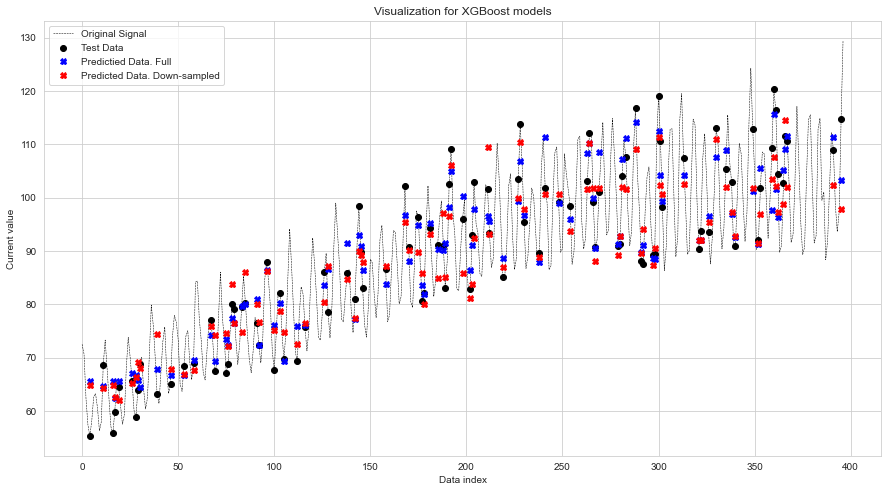

In [97]:
plt.figure(figsize = (15,8))
plt.plot(current_val,'--k',linewidth = 0.5)
plt.scatter(test_index,y_test,c='black')
plt.plot(test_index,pred_y_opt_all,'bX')
plt.plot(test_index,pred_y_opt_down,'rX')
plt.xlabel('Data index')
plt.ylabel('Current value')
plt.title('Visualization for XGBoost models')
plt.grid(True)
plt.legend(['Original Signal','Test Data','Predictied Data. Full','Predicted Data. Down-sampled'],loc = 'best')
plt.show()

----------------------------------------------------------------------------------------------------------------------------------

Visualization of the accuracy results for all models

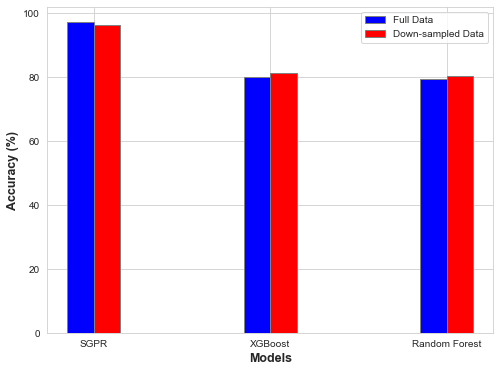

In [98]:
accuracy_all = [acc_sgpr_all, acc_xgb_all, acc_rf_all]
accuracy_down = [acc_sgpr_down, acc_xgb_down, acc_rf_down]

barWidth = 0.15
br1 = np.arange(len(accuracy_all))
br2 = [x + barWidth for x in br1]

fig = plt.subplots(figsize =(8, 6))
plt.bar(br1, accuracy_all, color = 'blue', width = barWidth, edgecolor = 'grey', label = 'Full Data')
plt.bar(br2, accuracy_down, color = 'red', width = barWidth, edgecolor = 'grey', label = 'Down-sampled Data')
plt.xlabel('Models', fontweight ='bold', fontsize = 12.5)
plt.ylabel('Accuracy (%)', fontweight ='bold', fontsize = 12.5)
plt.xticks([r + barWidth/2 for r in range(len(accuracy_all))], ['SGPR', 'XGBoost', 'Random Forest'])
plt.legend(loc = 'best')
plt.show()

##### Conclusions 
For this data set, the most efficient model was definitely the SGPR (Sparse Gaussian Process Regressor).                       
The down-sampling process may lead to a better accuracy in some situations.                                                     
The tuning of the hyperparameters worked, but the results were not improved considerably.